<a href="https://colab.research.google.com/github/LionelAgo/Vortex_AE/blob/master/Vortex_Sparse_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages + Drive

1 - Install necessary package

2 - Import packages

3- mount drive

In [1]:
# - 2
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import h5py



# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.14.0'

In [2]:
# - 3
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
import os
dir="/content/drive/My Drive/Colab Notebooks/Vortex/"
os.chdir(dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Jet data + Preprocessing

## Load data 
Data avaible: 
https://app.box.com/s/24wakswab2di53eu2l9wx6e65nf4nn2x

In [4]:
hf = h5py.File('U.h5', 'r')
U = hf.get('U')
U = np.array(U)
hf.close()
print(f'data downloaded')


data downloaded


##  Prepare Data for Autoencoder 


1.  **Feature scaling**

       - MinMaxScaler -> speed up training process (last layer: sigmoid)
2.  **build matrice with temporal shift for embbeded the dynamic** 
      - CNN with conv3d      
2. **Split the Data for training and validation**
      - multiple of 128 ( memory optimisation for TPU)
      - Temporel shift can be introduced between the input and ouput for reinforce the dynamic in Latent space


       
       





In [5]:
# - 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 0.99))

def scaleC(tmp='U'):
  nt,nx,nz=np.shape(tmp)
  tmp=np.reshape(tmp,(nt,nx*nz))
  tmp=scaler.fit_transform(tmp.T)
  tmp=tmp.T
  tmp=np.reshape(tmp,(nt,nx,nz,1))
  #tmp=np.expand_dims(tmp,axis=4)
  tmp=tmp[:,2:-2,2:,:]
  return tmp

U=scaleC(U)
#V=scaleC(V)
#Om=scaleC(Om)
#S=scaleC(S)
print(f'Database size_{np.shape(U)}')

Database size_(501, 256, 88, 1)


In [0]:

# - 2
def data4AE3d(v,dt=8):

  nt,nx,nz,nc=np.shape(v) 
  for i in np.arange(0,dt):
    t=v[i:int(nt-dt+i),:,:,:]
    t=np.expand_dims(t,1)
    if i==0:
      tmp=t
    else:
      tmp=np.concatenate((tmp,t),axis=1)
  return tmp  

dt=12
Ut=data4AE3d(U,dt)


In [0]:
# - 3
tshift=0
Utrain_1 = Ut[0:int(1*128),:,:,:,:].astype(np.float32)
Utrain_2 = Ut[tshift:int(tshift+1*128),:,:,:,:].astype(np.float32)

#Build Autoencoder (CCN)
   -  latent dimension define by : nl

In [8]:
#model=CAE_3L()
nl=3


def CAE_3L_comp(nl=int(nl)):
  
  nt,dt,nx,nz,nc=np.shape(Ut)
 
  filters=[8*2, 16*2, 32*2, nl]
  
  rate=0.0
  
  nm=8
  nm0=4
  
  actd=lambda x: tf.nn.leaky_relu(x, alpha=0.2)
  #act=lambda x: tf.nn.crelu(x)
  #act='relu'
  act=lambda x: tf.nn.elu(x)

  input_shape=(dt,nx,nz, nc)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GaussianNoise(rate, input_shape=input_shape, name='noise'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv3D(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='conv1')) #5
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same')) #2 2

  model.add(tf.keras.layers.Conv3D(filters[1], (3,3,3), strides=1, activation=act, padding='same', name='conv2'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same'))

  model.add(tf.keras.layers.Conv3D(filters[2], (3,3,3), activation=act, padding='same', name='conv3'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(1,2,2), strides=(1,2,2), padding='same'))


  model.add(tf.keras.layers.Flatten())
  #model.add(tf.keras.layers.Dense(units=filters[3],activity_regularizer=tf.keras.regularizers.l1_l2(l1=10e-6,l2=10e-6), name='bottleneck'))
  model.add(tf.keras.layers.Dense(units=filters[3],activation=act, name='bottleneck'))

  model.add(tf.keras.layers.Dense(units=filters[2]*int(input_shape[0]/nm0)*int(input_shape[1]/nm)*int(input_shape[2]/nm)))
  model.add(tf.keras.layers.Reshape((int(input_shape[0]/nm0), int(input_shape[1]/nm), int(input_shape[2]/nm) , filters[2])))

  model.add(tf.keras.layers.UpSampling3D((1,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[2], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv3'))
  model.add(tf.keras.layers.UpSampling3D((2,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[1], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv2'))
  model.add(tf.keras.layers.UpSampling3D((2, 2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv1'))
  model.add(tf.keras.layers.Conv3DTranspose(1, (1,1,1), activation='sigmoid', padding='same', name='last'))
  

  
  return model

model=CAE_3L_comp()
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 12, 256, 88, 1)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 256, 88, 1)    4         
_________________________________________________________________
conv1 (Conv3D)               (None, 12, 256, 88, 16)   2016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 128, 44, 16)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 6, 128, 44, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 64, 22, 32)     0         
____

## setup connection to TPU

In [10]:

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)



INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.122.254.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5944249819975566137)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18302842934271651198)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12058902124762099372)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3441570588608623208)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17

## Define  loss functions

1.   **quantile_loss**  
     - q=0.5 similar to mean square error (similar to POD for linear activation function)
     - q<0.5 more accuracy for negative-fluctuation events
     - q>0.5 more accuracy for positive-fluctuation events
2.   **resemblance**

      - I created this function in order to measure the likeness between the original and predicted image.
      
                ***Rs*** factor is not weighted by energy and Rs<=1

     
    

In [0]:

def quantile_loss(y_true, y_pred):
    q=0.5 # similar to mae
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q*e, (q-1)*e), axis=-1)


def resemblance(y_true, y_pred):
    q=64
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return tf.reduce_mean(alp)
  
  

In [0]:
with strategy.scope():
  model = CAE_3L_comp()
  model.compile(
      optimizer=tf.keras.optimizers.Adamax(),
      loss=resemblance,
      metrics=['mape'])

# Train and evaluate model


1.   Train
2.   Evaluate
3.  Save



In [0]:
#model=CAE_3L_conv()
namesave=f'Vs_{nl}dim_dt{dt}'                
model.load_weights(namesave+'.h5')


history=model.fit(
          Utrain_1, Utrain_2,
          epochs=2048, #64
          steps_per_epoch=8, 
          )

namesave=f'Vs_{nl}dim_dt{dt}_v2'               
model.save_weights(namesave+'.h5', overwrite=True)
print(f'Saved model to disk - {namesave}')
prout

**Plot  training history**

In [0]:
print(history.history.keys())


In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
#plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(left=400)
#plt.ylim(top=1.5)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Load model

In [13]:

#model=CAE_3L_comp()
namesave=f'Vs_{nl}dim_dt{dt}_v2'                
#model.load_weights(namesave+'.h5')
print("model Loaded from disk")

with strategy.scope():
  model = CAE_3L_comp()
  model.compile(
      optimizer=tf.keras.optimizers.Adamax(),
      loss=resemblance,
      metrics=['mape'])
  model.load_weights(namesave+'.h5')


model Loaded from disk


# Evaluation model 

In [14]:

model.evaluate(Ut[-128:,:,:,:,:].astype(np.float32), Ut[-128:,:,:,:,:].astype(np.float32))
#np.shape(X1_val)

4/4 [==============================] - 14s 4s/step


[0.0012091558310203254, 0.40211412]

# Auto-Encoder

## Encoder - Decoder

In [0]:

# Decoder  for CAE_3L_comp()

def define_dec():
  encoder = tf.keras.Model(model.input, model.get_layer('bottleneck').output)

  input_img = tf.keras.Input(shape=(nl,))
  K=10
  dec_1 = model.layers[int(K)]
  dec_2 = model.layers[int(K+1)]
  dec_3 = model.layers[int(K+2)]
  dec_4 = model.layers[int(K+3)]
  dec_5 = model.layers[int(K+4)]
  dec_6 = model.layers[int(K+5)]
  dec_7 = model.layers[int(K+6)]
  dec_8 = model.layers[int(K+7)]
  dec_9 = model.layers[int(K+8)]
  decoder = tf.keras.Model(input_img, ((dec_9(dec_8(dec_7(dec_6(dec_5(dec_4(dec_3(dec_2(dec_1(input_img))))))))))))
 
  return encoder, decoder    

encoder, decoder = define_dec() 

In [0]:
#X1=Ut[:,:,:,:,:].astype(np.float32)
#Renc = model.predict(X1)

## Encoding and Decoding
**dimensionality reduction:**
- Encoder --> Latent space (Zenc)
---

In [16]:

X1=Ut[:,:,:,:,:].astype(np.float32)
Zenc = encoder.predict(X1)
print(f'size_of_latent_dim_{np.shape(Zenc)}')

size_of_latent_dim_(489, 3)


**Reconstruct:**
 - Latent space --> Decoder (Renc)
---


In [0]:
if 1==2:
  import time
  start = time.process_time()
  Renc=decoder.predict(Zenc[:,:])
  print(f'size_of_reconstructed_field_{np.shape(Renc)}')
  print(time.process_time() - start)
  Renc=np.squeeze(Renc[:,0,:,:,0])
  hf = h5py.File('Renc.h5', 'w')
  hf.create_dataset('Renc', data=Renc, compression='gzip')
  hf.close()   

else:
  hf = h5py.File('Renc.h5', 'r')
  n1 = hf.get('Renc')
  Renc = np.array(n1)
  hf.close()

## Reconstruct field and Visualisation 

In [0]:
def np_resemblance(y_true, y_pred):
    q=8
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return alp

snapshot 408


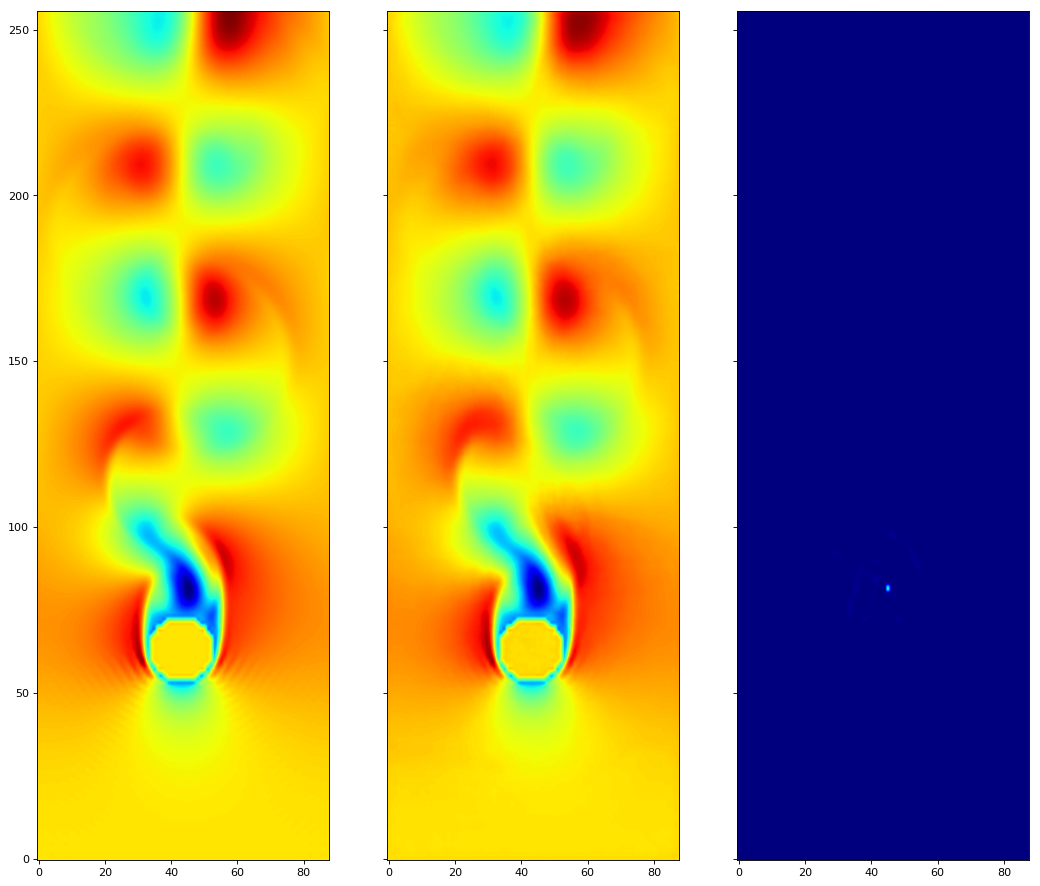

In [20]:
delta_t=0
dti=0
nt=500
ni=np.random.randint(0,nt)
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(X1[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
               
tmpi=np.squeeze(Renc[ni,:,:])                
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')

alp=np_resemblance(tmp, tmpi)
z_min, z_max = alp.min(),alp.max()
ax3.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')

#print(f'{z_min}_{z_max}_mean_{np.mean(alp)}')



(0, 512)

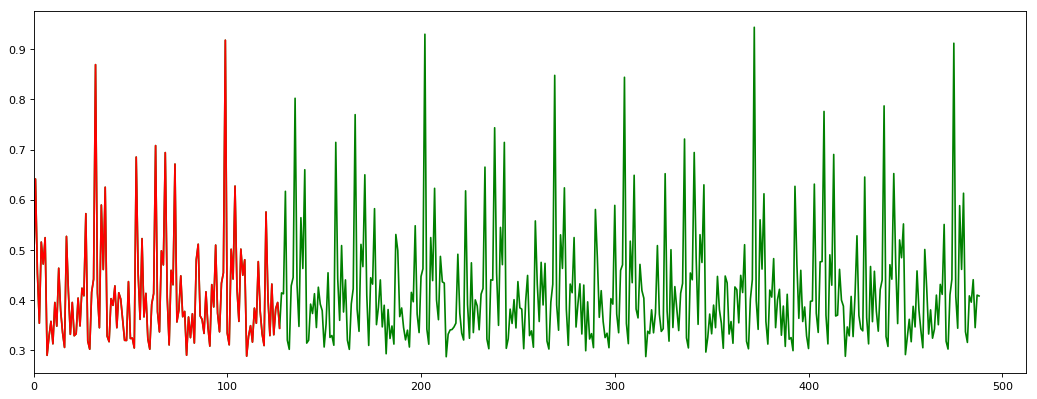

In [21]:
ix=0
n=0
VRenc=[]
VPod=[]
#dp=Ut[:,0,:,:,:]
xl=range(0,88)

for ni in range(Ut.shape[0]):
  ix +=1
  tmp=np.squeeze(Ut[ni+delta_t,0,:,:,n])  
  tmp2=np.squeeze(Renc[ni,:,:]) 
  val=0
  nn=1
  val=100*np.mean(abs(tmp2[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))
  #np.shape(val)
  if ix==1:
    VRenc=val
  else:
    VRenc=np.vstack((VRenc,val))

    

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[:1*128],'r-')
ax.set_xlim(0,4*128)
#ax.set_ylim(0,0.2)





# Sparse Reconstruction from sensors


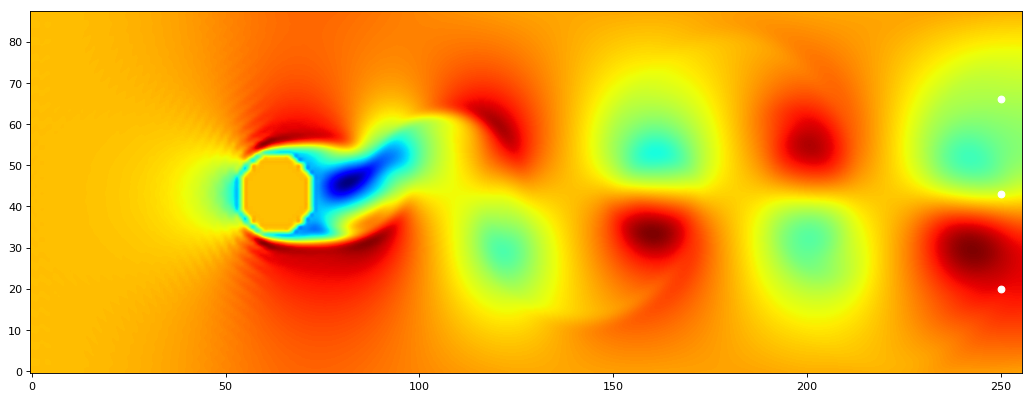

In [42]:
_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
tmp=np.squeeze(Utrain_1[0,0,:,:,0].T)
zmin=1*tmp.min()
zmax=1*tmp.max()

ax.imshow(tmp, cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='auto', origin='low')
ax.plot(250,20,'wo')
ax.plot(250,43,'wo')
ax.plot(250,66,'wo')

Sens=Ut[:,0,250,20,0]
Sens=np.expand_dims(Sens,1)
Sens=np.concatenate((Sens,np.expand_dims(Ut[:,0,250,43,0],1)),1)
Sens=np.concatenate((Sens,np.expand_dims(Ut[:,0,250,66,0],1)),1)


## Prepare data for temporal convolational network
  - sensors
  - latent space 

In [43]:


## pre-processing sensors data
Sens=np.expand_dims(Sens,4)
Sens=np.expand_dims(Sens,4)
dt=12
Sens=data4AE3d(Sens,dt)
Sens=np.squeeze(Sens)
print(f'size_of_Sensor_matrix{np.shape(Sens)}')



## pre-processing Latent data
Zenca=Zenc
mini=Zenc.min()
mini=8*mini
maxi=Zenc.max()
Zenca= (Zenca-mini)/(maxi-mini)

Zenca=np.expand_dims(Zenca,4)
Zenca=np.expand_dims(Zenca,4)

dt=12
Zenca=data4AE3d(Zenca,dt)
Zenca=np.squeeze(Zenca)


size_of_Sensor_matrix(477, 12, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


## Define temporal CNN for estimating Zenc from sensors

In [44]:


def Csparse():
  
  nt,dt, nc=np.shape(Zenca)
 
  filters=[32, 64, 128, nl]
  
  rate=0.0
  
  nm=1
  nm0=1
  
  actd=lambda x: tf.nn.leaky_relu(x, alpha=0.2)
  #act=lambda x: tf.nn.crelu(x)
  #act='relu'
  act=lambda x: tf.nn.elu(x)

  input_shape=(dt, nc)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GaussianNoise(rate, input_shape=input_shape, name='noise'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.SeparableConv1D(filters[0], 6,  activation=act, padding='same', name='conv1')) #5
  
  model.add(tf.keras.layers.SeparableConv1D(filters[1], 5,  activation=act, padding='same', name='conv2'))
  
  model.add(tf.keras.layers.SeparableConv1D(filters[2], 4, activation=act, padding='same', name='conv3'))

  model.add(tf.keras.layers.SeparableConv1D(filters[1], 5,  activation=act, padding='same', name='conv4'))

  model.add(tf.keras.layers.SeparableConv1D(filters[0], 6,  activation=act, padding='same', name='conv5')) #5

  model.add(tf.keras.layers.SeparableConv1D(3, 1, activation='sigmoid', padding='same', name='last'))
  model.summary()

  
  return model

model=Csparse()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 12, 3)             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 3)             12        
_________________________________________________________________
conv1 (SeparableConv1D)      (None, 12, 32)            146       
_________________________________________________________________
conv2 (SeparableConv1D)      (None, 12, 64)            2272      
_________________________________________________________________
conv3 (SeparableConv1D)      (None, 12, 128)           8576      
_________________________________________________________________
conv4 (SeparableConv1D)      (None, 12, 64)            8896      
_________________________________________________________________
conv5 (SeparableConv1D)      (None, 12, 32)           

## Reconstruction from Sensors
**Only the first 128 iterations are used for training**
 

1.   Training on TPU 
2.   Predict latent from Sensors
3.   Reconstruct field from Latent

*step 1 and 2 can be skipped - data already compiled*



###**1 - Training on TPU**

In [25]:
#  Compile on TPU

with strategy.scope():
  model_sparse = Csparse()
  model_sparse.compile(
      optimizer=tf.keras.optimizers.Adamax(),
      loss='logcosh',
      metrics=['mape'])
  



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 12, 3)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 3)             12        
_________________________________________________________________
conv1 (SeparableConv1D)      (None, 12, 32)            146       
_________________________________________________________________
conv2 (SeparableConv1D)      (None, 12, 64)            2272      
_________________________________________________________________
conv3 (SeparableConv1D)      (None, 12, 128)           8576      
_________________________________________________________________
conv4 (SeparableConv1D)      (None, 12, 64)            8896      
_________________________________________________________________
conv5 (SeparableConv1D)      (None, 12, 32)           

In [0]:
#  Training on TPU

history=model_sparse.fit(
          Sens[:128,:,:].astype(np.float32), Zenca[:128,:,:],
          epochs=int(2048*4), #64
          steps_per_epoch=1,
         )

In [0]:
# Evaluation
model_sparse.evaluate(Sens[-128:,:,:].astype(np.float32), Zenca[-128:,:,:])


In [0]:
#  Save model
namesave=f'Sensor2Lat'               
model_sparse.save_weights(namesave+'.h5', overwrite=True)
print(f'Saved model to disk - {namesave}')

###**2 - Predict latent space from Sensors**

In [0]:

Zenc_rec=model_sparse.predict(Sens.astype(np.float32))
Zenc_rec=np.squeeze(Zenc_rec[:,0,:])
Zenc_rec=Zenc_rec * (maxi-mini) + mini

plt.plot(Zenc[:24,:],'r')
plt.plot(Zenc_rec[:24,:],'b')

hf = h5py.File('Zenc_sparse.h5', 'w')
hf.create_dataset('Zenc_rec', data=Zenc_rec)
hf.close()     


###**3 -Reconstruct field from Latent**

In [0]:


if 1==2:
  hf = h5py.File('Zenc_sparse.h5', 'r')
  n1 = hf.get('Zenc_rec')
  Zenc_rec = np.array(n1)
  hf.close()

  namesave=f'Vs_{nl}dim_dt{dt}_v2'   # 3 - 12             
  with strategy.scope():
    model = CAE_3L_comp()
    model.compile(
       optimizer=tf.keras.optimizers.Adamax(),
        loss=resemblance,
        metrics=['mape'])
    model.load_weights(namesave+'.h5')
  encoder, decoder = define_dec(1) 
  Renc_Sparse=decoder.predict(Zenc_rec)
  Renc_Sparse=np.squeeze(Renc_Sparse[:,0,:,:,0])
  hf = h5py.File('Renc_sparse.h5', 'w')
  hf.create_dataset('Renc_Sparse', data=Renc_Sparse, compression='gzip')
  hf.close() 
else:
  hf = h5py.File('Renc_sparse.h5', 'r')
  n1 = hf.get('Renc_Sparse')
  Renc_Sparse = np.array(n1)
  hf.close()

## Visualitations

snapshot 177


Text(0.5, 1.0, 'Reconstruct from autoencoder using sensors')

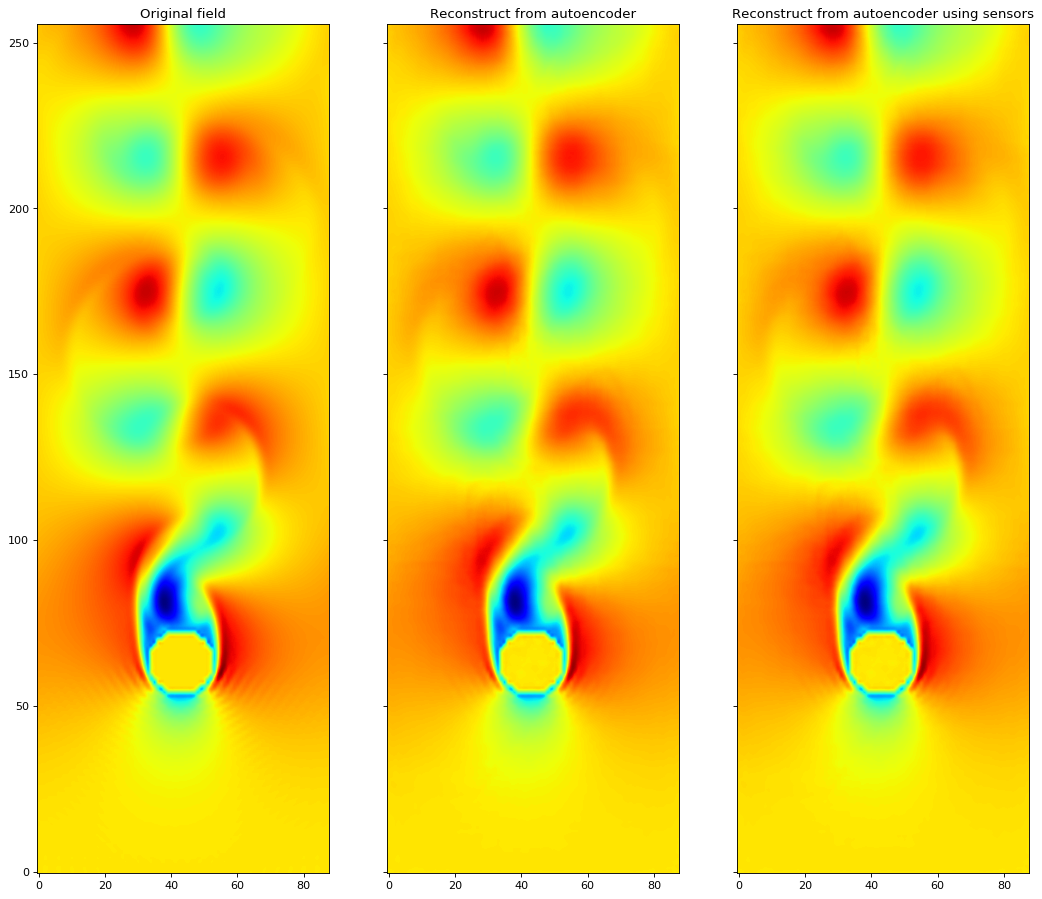

In [46]:
delta_t=0
dti=0
nt=489
ni=np.random.randint(0,nt)
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(X1[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax1.set_title('Original field')

tmpi=np.squeeze(Renc[ni,:,:])                
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax2.set_title('Reconstruct from autoencoder')

tmpi=np.squeeze(Renc_Sparse[ni,:,:])                
ax3.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax3.set_title('Reconstruct from autoencoder using sensors')




## Error estimation

$Xori$: original field

$Xrec$: reconstructed field

\begin{align}
\phi^n & = 100 \times \int\int\frac{\sqrt{(Xrec^n - Xori^n)^2}}{Xori^n} dx dz
\end{align}

(0, 480)

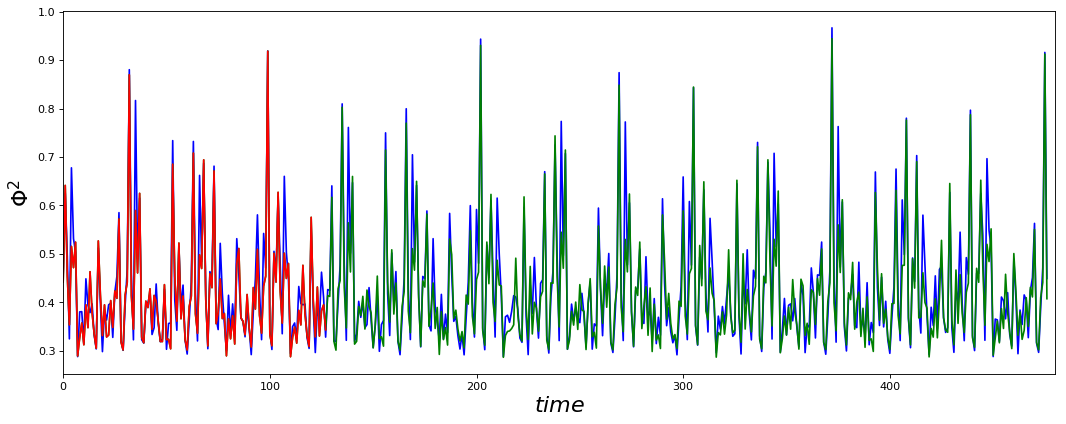

In [47]:
ix=0
n=0
VRenc=[]

#dp=Ut[:,0,:,:,:]
xl=range(0,88)

for ni in range(Renc_Sparse.shape[0]):
  ix +=1
  tmp=np.squeeze(Ut[ni+delta_t,0,:,:,n]) 
  tmp2=np.squeeze(Renc[ni,:,:]) 
  tmp3=np.squeeze(Renc_Sparse[ni,:,:]) 
  val2=0
  val3=0

  nn=1
  val2=100*np.mean(abs(tmp2[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))
  val3=100*np.mean(abs(tmp3[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))

  #np.shape(val)
  if ix==1:
    VRenc2=val2
    VRenc3=val3

  else:
    VRenc2=np.vstack((VRenc2,val2))
    VRenc3=np.vstack((VRenc3,val3))

    

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc3,'b-')
ax.plot(VRenc2,'g-')

ax.plot(VRenc2[:1*128],'r-')
ax.set_xlim(0,4*128)
ax.set_ylabel('$\Phi^2$', fontsize=20)
ax.set_xlabel('$time$', fontsize=20)
#ax.set_ylim(0,0.2)
ax.set_xlim(0,480)



